In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import nibabel as nib
import nilearn

from scipy.ndimage.interpolation import zoom
from sklearn.utils import shuffle
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
import os
import time
import h5py

# keras
from keras.models import Sequential
from keras.layers import Input, Conv3D, Flatten, Dense, MaxPooling3D, Dropout
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import Sequence

from config import *
from utils import specificity
from utils import sensitivity

Using TensorFlow backend.


In [3]:
# Start timing
start_time = time.time()

In [4]:
# Tensorflow settings
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session, get_session

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.visible_device_list = "6"
sess = tf.Session(config=config)
set_session(sess)

In [5]:
dtype = np.float32
result_dir = "/analysis/share/Ritter/models/fabi/ADNI/pretraining_paper/"

In [6]:
!mkdir -p $result_dir

In [7]:
# load hdf5 files and extract columns
train_h5 = h5py.File("/analysis/share/ADNI/HDF5_files/train_2yr_and_unique_screening-921_subjects-96_114_96_shape-masked.h5", 'r')
holdout_h5 = h5py.File("/analysis/share/ADNI/HDF5_files/test_2yr_and_unique_screening-150_subjects-96_114_96_shape-masked.h5", 'r')

X_train, y_train, files_train = train_h5['X'], train_h5['y'], train_h5["files"]
X_holdout, y_holdout = holdout_h5['X'], holdout_h5['y']

In [8]:
# convert data to numpy arrays
X_train = np.expand_dims(np.array(X_train, dtype=dtype), 4)
y_train = np.array(y_train)

X_holdout = np.expand_dims(np.array(X_holdout, dtype=dtype), 4)
y_holdout = np.array(y_holdout)

In [9]:
print("Total datset length: {}".format(len(y_train)))
print("Number of healthy controls: {}".format(len(np.array(y_train)[np.array(y_train)==0.])))
print("Number of AD patients: {}".format(len(np.array(y_train)[np.array(y_train)==1.])))

Total datset length: 921
Number of healthy controls: 464
Number of AD patients: 457


In [10]:
class ADNIDataset(Sequence):
    def __init__(self, X, y, transform=None, batch_size=4, z_factor=None, shuffle=True, mask=None):
        self.X = X
        self.y = y
        self.transform = transform
        self.batch_size = batch_size
        self.z_factor = z_factor
        self.shuffle = shuffle
        self.mask = mask
        
    def __len__(self):
        return int(np.ceil(len(self.y)/self.batch_size))
    
    def __getitem__(self, idx):
        # add BET
        image = np.expand_dims(self.X[idx * self.batch_size:(idx + 1) * self.batch_size],5)
        label = np.array(self.y[idx * self.batch_size:(idx + 1) * self.batch_size], dtype=np.int8)
        
        if self.mask is not None:
            for i in range(image.shape[0]):
                image[i] *= self.mask
        
        for transformation in self.transform:
            image = transformation(image)
        
        return image, label
    
    def on_epoch_end(self):
        if self.shuffle:
            self.X, self.y = shuffle(self.X, self.y)

In [11]:
# images are already masked
mask = None

# Model

In [12]:
def SixtyFourNet(input_shape, drop_rate=0., weight_dcay=0.):
    model = Sequential()
    model.add(Conv3D(64, kernel_size=3, 
                     input_shape=(input_shape[1], input_shape[2], input_shape[3], 1), 
                     activation='elu', padding='valid', name='Conv_1'))
    model.add(MaxPooling3D(pool_size=3, name='Pool_1'))
    model.add(Dropout(drop_rate))
    model.add(Conv3D(64, kernel_size=3, padding='valid', activation='elu', name='Conv_2'))

    model.add(MaxPooling3D(pool_size=3, name='Pool_2'))
    model.add(Dropout(drop_rate))

    model.add(Conv3D(64, kernel_size=3, padding='valid', activation='elu', name='Conv_3',
                     kernel_regularizer=l2(weight_dcay)))
    model.add(Conv3D(64, kernel_size=3, padding='valid', activation='elu', name='Conv_4',
                     kernel_regularizer=l2(weight_dcay)))
    model.add(MaxPooling3D(pool_size=3, name='Pool_4'))
    model.add(Dropout(drop_rate))

    model.add(Flatten())
    model.add(Dense(units=1, activation='sigmoid'))
    return model

# Normalization

In [13]:
files_train = np.array(files_train)

In [14]:
import re
def return_subject_ID(string):
    """ Match subject IDs with the pattern: [3 digits]_S_[4 digits]"""
    subject_ID = re.search('(\d{3}_S_\d{4})', string)
    return subject_ID.group(0)

In [15]:
names_train = [return_subject_ID(item.decode('utf-8')) for item in files_train]

### Normalize min-max

In [16]:
for i in range(len(X_train)):
    X_train[i] -= np.min(X_train[i])
    X_train[i] /= np.max(X_train[i])
    
for i in range(len(X_holdout)):
    X_holdout[i] -= np.min(X_holdout[i])
    X_holdout[i] /= np.max(X_holdout[i])

### Normalize by voxel and split data

In [17]:
GSS = GroupShuffleSplit(n_splits=1, test_size=0.15, random_state=22)
indices = list(GSS.split(names_train, groups=names_train))[0]
train_idx, val_idx = indices[0], indices[1]

mean = np.mean(X_train[train_idx], axis=0)
std = np.std(X_train[train_idx], axis=0)
X_train = (X_train - mean) / (std)

In [18]:
# shuffle indices test
np.random.shuffle(train_idx)
np.random.shuffle(val_idx)

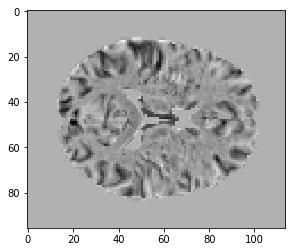

In [19]:
plt.imshow(X_train[4][:,:,46,0], cmap='gray')
plt.show()

# Training

Train on 801 samples, validate on 120 samples
Epoch 1/45
801/801 [==============================] - 38s 48ms/step - loss: 2.0547 - acc: 0.5356 - val_loss: 1.7491 - val_acc: 0.5583
Epoch 2/45
801/801 [==============================] - 35s 44ms/step - loss: 1.6404 - acc: 0.5568 - val_loss: 1.4560 - val_acc: 0.6500
Epoch 3/45
801/801 [==============================] - 36s 45ms/step - loss: 1.2662 - acc: 0.7141 - val_loss: 1.1816 - val_acc: 0.6583
Epoch 4/45
801/801 [==============================] - 36s 45ms/step - loss: 1.0055 - acc: 0.7640 - val_loss: 0.9190 - val_acc: 0.7333
Epoch 5/45
801/801 [==============================] - 36s 44ms/step - loss: 0.8519 - acc: 0.7978 - val_loss: 0.9982 - val_acc: 0.6750
Epoch 6/45
801/801 [==============================] - 35s 44ms/step - loss: 0.7872 - acc: 0.7528 - val_loss: 0.7117 - val_acc: 0.8000
Epoch 7/45
801/801 [==============================] - 36s 45ms/step - loss: 0.6250 - acc: 0.8152 - val_loss: 0.6619 - val_acc: 0.7750
Epoch 8/45
801/8

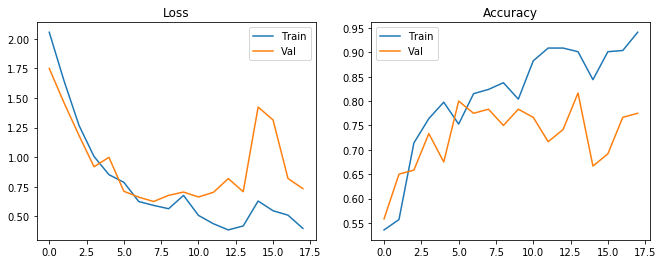

Final epoch results:
Balanced Accuracy: 76.70 %
Sensitivity: 83.58 %
Specificity: 69.81 %
Train on 801 samples, validate on 120 samples
Epoch 1/45
801/801 [==============================] - 35s 44ms/step - loss: 2.1195 - acc: 0.5019 - val_loss: 1.7065 - val_acc: 0.5250
Epoch 2/45
801/801 [==============================] - 35s 44ms/step - loss: 1.6072 - acc: 0.6117 - val_loss: 1.3715 - val_acc: 0.6667
Epoch 3/45
801/801 [==============================] - 35s 44ms/step - loss: 1.2163 - acc: 0.7303 - val_loss: 1.0914 - val_acc: 0.7667
Epoch 4/45
801/801 [==============================] - 36s 45ms/step - loss: 1.0816 - acc: 0.7203 - val_loss: 1.0242 - val_acc: 0.6917
Epoch 5/45
801/801 [==============================] - 36s 44ms/step - loss: 0.8824 - acc: 0.7591 - val_loss: 0.9012 - val_acc: 0.7417
Epoch 6/45
801/801 [==============================] - 35s 44ms/step - loss: 0.7982 - acc: 0.7753 - val_loss: 0.7543 - val_acc: 0.7833
Epoch 7/45
801/801 [==============================] - 35s 44

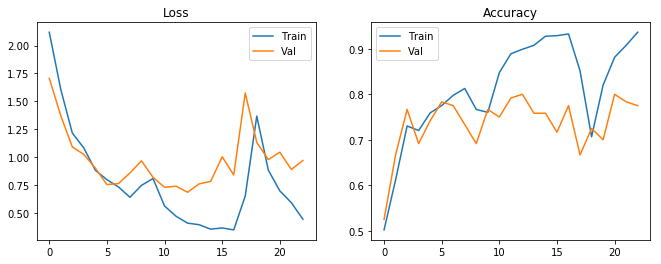

Final epoch results:
Balanced Accuracy: 76.70 %
Sensitivity: 83.58 %
Specificity: 69.81 %
Train on 801 samples, validate on 120 samples
Epoch 1/45
801/801 [==============================] - 35s 44ms/step - loss: 1.9957 - acc: 0.5106 - val_loss: 1.7165 - val_acc: 0.5583
Epoch 2/45
801/801 [==============================] - 36s 44ms/step - loss: 1.6110 - acc: 0.5768 - val_loss: 1.3624 - val_acc: 0.6667
Epoch 3/45
801/801 [==============================] - 35s 44ms/step - loss: 1.2729 - acc: 0.6592 - val_loss: 1.2797 - val_acc: 0.5833
Epoch 4/45
801/801 [==============================] - 35s 44ms/step - loss: 0.9952 - acc: 0.7353 - val_loss: 0.9735 - val_acc: 0.7167
Epoch 5/45
801/801 [==============================] - 35s 44ms/step - loss: 0.8653 - acc: 0.7690 - val_loss: 0.8378 - val_acc: 0.7417
Epoch 6/45
801/801 [==============================] - 35s 44ms/step - loss: 0.7324 - acc: 0.7990 - val_loss: 0.7595 - val_acc: 0.7917
Epoch 7/45
801/801 [==============================] - 35s 44

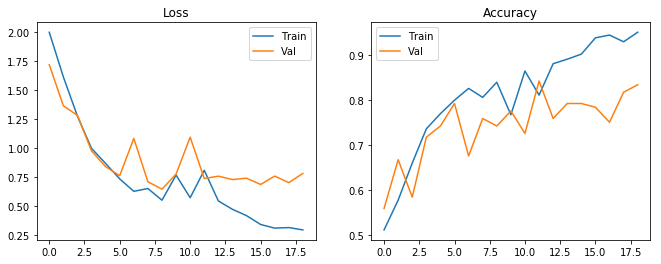

Final epoch results:
Balanced Accuracy: 82.91 %
Sensitivity: 86.57 %
Specificity: 79.25 %
Train on 801 samples, validate on 120 samples
Epoch 1/45
801/801 [==============================] - 36s 44ms/step - loss: 2.0137 - acc: 0.5268 - val_loss: 1.7224 - val_acc: 0.4500
Epoch 2/45
801/801 [==============================] - 36s 45ms/step - loss: 1.5987 - acc: 0.5468 - val_loss: 1.5211 - val_acc: 0.4500
Epoch 3/45
801/801 [==============================] - 36s 44ms/step - loss: 1.2649 - acc: 0.5918 - val_loss: 1.1390 - val_acc: 0.5917
Epoch 4/45
801/801 [==============================] - 35s 44ms/step - loss: 1.1495 - acc: 0.6117 - val_loss: 0.9609 - val_acc: 0.6417
Epoch 5/45
801/801 [==============================] - 35s 44ms/step - loss: 1.1716 - acc: 0.5331 - val_loss: 0.9938 - val_acc: 0.7000
Epoch 6/45
801/801 [==============================] - 36s 44ms/step - loss: 1.0358 - acc: 0.6092 - val_loss: 1.0418 - val_acc: 0.6083
Epoch 7/45
801/801 [==============================] - 36s 45

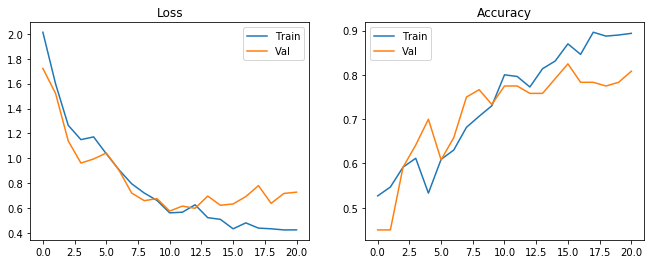

Final epoch results:
Balanced Accuracy: 80.27 %
Sensitivity: 85.07 %
Specificity: 75.47 %
Train on 801 samples, validate on 120 samples
Epoch 1/45
801/801 [==============================] - 36s 45ms/step - loss: 2.0427 - acc: 0.5031 - val_loss: 1.8268 - val_acc: 0.4750
Epoch 2/45
801/801 [==============================] - 35s 44ms/step - loss: 1.6316 - acc: 0.5680 - val_loss: 1.3901 - val_acc: 0.6750
Epoch 3/45
801/801 [==============================] - 35s 44ms/step - loss: 1.2921 - acc: 0.6692 - val_loss: 1.1197 - val_acc: 0.6417
Epoch 4/45
801/801 [==============================] - 35s 44ms/step - loss: 1.1806 - acc: 0.6841 - val_loss: 1.3127 - val_acc: 0.5500
Epoch 5/45
801/801 [==============================] - 35s 44ms/step - loss: 1.0824 - acc: 0.6841 - val_loss: 0.9569 - val_acc: 0.7083
Epoch 6/45
801/801 [==============================] - 35s 44ms/step - loss: 0.8489 - acc: 0.7478 - val_loss: 0.8200 - val_acc: 0.7667
Epoch 7/45
801/801 [==============================] - 35s 44

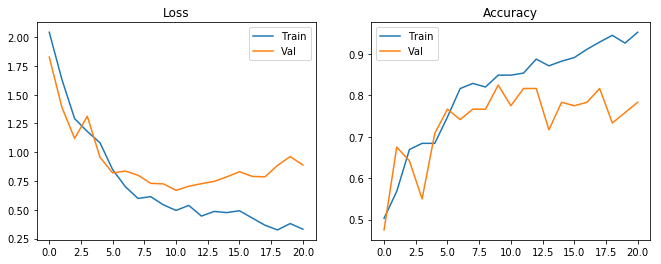

Final epoch results:
Balanced Accuracy: 77.05 %
Sensitivity: 88.06 %
Specificity: 66.04 %
Train on 801 samples, validate on 120 samples
Epoch 1/45
801/801 [==============================] - 36s 45ms/step - loss: 1.9786 - acc: 0.5281 - val_loss: 1.6238 - val_acc: 0.6083
Epoch 2/45
801/801 [==============================] - 35s 44ms/step - loss: 1.5070 - acc: 0.6479 - val_loss: 1.3720 - val_acc: 0.6000
Epoch 3/45
801/801 [==============================] - 35s 44ms/step - loss: 1.2036 - acc: 0.6879 - val_loss: 1.0935 - val_acc: 0.6750
Epoch 4/45
801/801 [==============================] - 36s 44ms/step - loss: 0.9892 - acc: 0.7216 - val_loss: 0.8961 - val_acc: 0.7833
Epoch 5/45
801/801 [==============================] - 35s 44ms/step - loss: 0.8208 - acc: 0.7715 - val_loss: 0.8322 - val_acc: 0.7583
Epoch 6/45
801/801 [==============================] - 35s 44ms/step - loss: 0.7725 - acc: 0.7790 - val_loss: 0.7767 - val_acc: 0.7000
Epoch 7/45
801/801 [==============================] - 35s 44

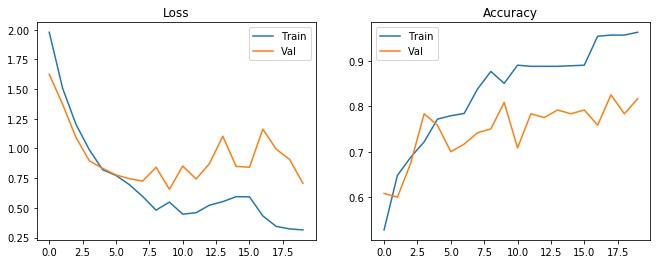

Final epoch results:
Balanced Accuracy: 82.60 %
Sensitivity: 74.63 %
Specificity: 90.57 %
Train on 801 samples, validate on 120 samples
Epoch 1/45
801/801 [==============================] - 36s 45ms/step - loss: 1.9982 - acc: 0.5119 - val_loss: 1.6264 - val_acc: 0.6000
Epoch 2/45
801/801 [==============================] - 35s 44ms/step - loss: 1.6082 - acc: 0.5730 - val_loss: 1.3770 - val_acc: 0.6500
Epoch 3/45
801/801 [==============================] - 35s 44ms/step - loss: 1.2782 - acc: 0.6429 - val_loss: 1.1609 - val_acc: 0.6667
Epoch 4/45
801/801 [==============================] - 35s 44ms/step - loss: 0.9925 - acc: 0.7166 - val_loss: 0.9315 - val_acc: 0.7000
Epoch 5/45
801/801 [==============================] - 35s 44ms/step - loss: 0.8539 - acc: 0.7578 - val_loss: 0.9185 - val_acc: 0.6833
Epoch 6/45
801/801 [==============================] - 35s 44ms/step - loss: 0.7932 - acc: 0.7516 - val_loss: 0.8497 - val_acc: 0.7083
Epoch 7/45
801/801 [==============================] - 35s 44

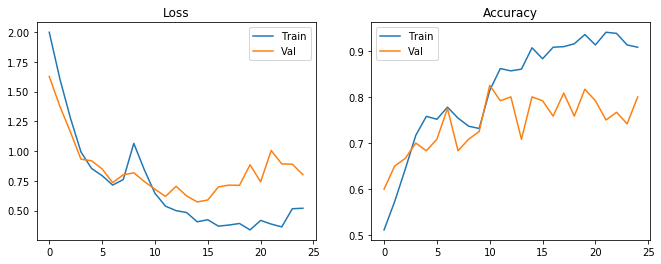

Final epoch results:
Balanced Accuracy: 79.33 %
Sensitivity: 85.07 %
Specificity: 73.58 %
Train on 801 samples, validate on 120 samples
Epoch 1/45
801/801 [==============================] - 35s 44ms/step - loss: 2.0615 - acc: 0.5181 - val_loss: 1.6774 - val_acc: 0.6500
Epoch 2/45
801/801 [==============================] - 35s 44ms/step - loss: 1.6830 - acc: 0.5293 - val_loss: 1.3999 - val_acc: 0.5583
Epoch 3/45
801/801 [==============================] - 35s 44ms/step - loss: 1.3256 - acc: 0.5793 - val_loss: 1.1644 - val_acc: 0.6083
Epoch 4/45
801/801 [==============================] - 35s 44ms/step - loss: 1.0064 - acc: 0.7129 - val_loss: 0.9246 - val_acc: 0.7250
Epoch 5/45
801/801 [==============================] - 35s 44ms/step - loss: 0.8833 - acc: 0.7241 - val_loss: 0.9307 - val_acc: 0.7250
Epoch 6/45
801/801 [==============================] - 35s 44ms/step - loss: 0.9961 - acc: 0.6380 - val_loss: 0.9230 - val_acc: 0.6750
Epoch 7/45
801/801 [==============================] - 35s 44

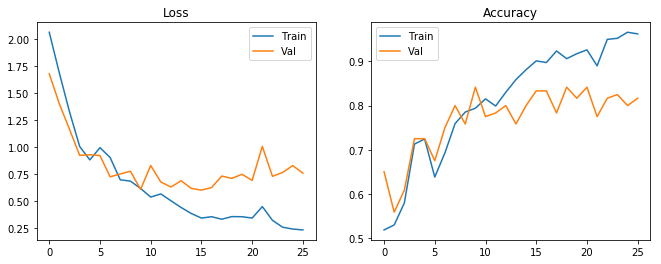

Final epoch results:
Balanced Accuracy: 82.99 %
Sensitivity: 71.64 %
Specificity: 94.34 %
Train on 801 samples, validate on 120 samples
Epoch 1/45
801/801 [==============================] - 37s 46ms/step - loss: 1.9980 - acc: 0.5693 - val_loss: 1.7821 - val_acc: 0.4750
Epoch 2/45
801/801 [==============================] - 35s 44ms/step - loss: 1.6005 - acc: 0.5780 - val_loss: 1.4900 - val_acc: 0.5500
Epoch 3/45
801/801 [==============================] - 35s 44ms/step - loss: 1.2439 - acc: 0.6866 - val_loss: 1.1279 - val_acc: 0.7000
Epoch 4/45
801/801 [==============================] - 35s 44ms/step - loss: 1.0267 - acc: 0.7253 - val_loss: 0.9216 - val_acc: 0.7417
Epoch 5/45
801/801 [==============================] - 35s 44ms/step - loss: 0.9052 - acc: 0.7341 - val_loss: 0.8214 - val_acc: 0.7750
Epoch 6/45
801/801 [==============================] - 35s 44ms/step - loss: 0.8169 - acc: 0.7803 - val_loss: 0.9004 - val_acc: 0.6667
Epoch 7/45
801/801 [==============================] - 35s 44

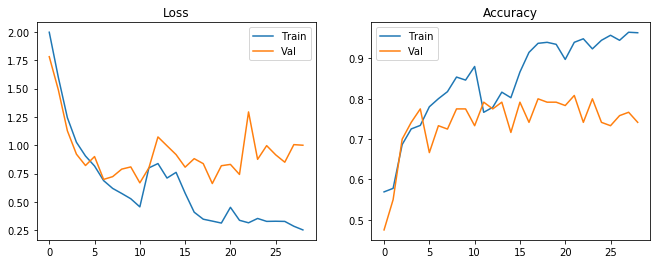

Final epoch results:
Balanced Accuracy: 73.51 %
Sensitivity: 79.10 %
Specificity: 67.92 %
Train on 801 samples, validate on 120 samples
Epoch 1/45
801/801 [==============================] - 36s 45ms/step - loss: 2.0490 - acc: 0.5069 - val_loss: 1.6252 - val_acc: 0.6583
Epoch 2/45
801/801 [==============================] - 35s 44ms/step - loss: 1.5962 - acc: 0.5581 - val_loss: 1.3425 - val_acc: 0.6500
Epoch 3/45
801/801 [==============================] - 35s 44ms/step - loss: 1.3331 - acc: 0.5943 - val_loss: 1.1268 - val_acc: 0.6417
Epoch 4/45
801/801 [==============================] - 35s 44ms/step - loss: 1.0733 - acc: 0.6829 - val_loss: 1.1271 - val_acc: 0.5917
Epoch 5/45
801/801 [==============================] - 35s 44ms/step - loss: 0.9004 - acc: 0.7328 - val_loss: 0.8619 - val_acc: 0.6917
Epoch 6/45
801/801 [==============================] - 35s 44ms/step - loss: 0.7639 - acc: 0.7903 - val_loss: 0.7441 - val_acc: 0.7750
Epoch 7/45
801/801 [==============================] - 35s 44

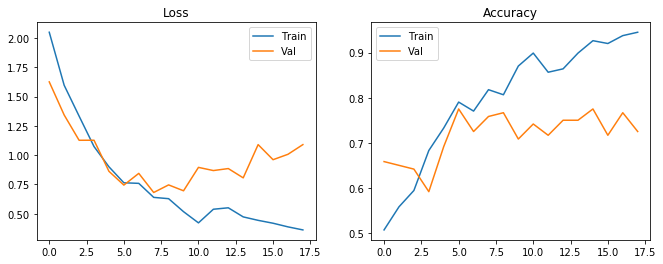

Final epoch results:
Balanced Accuracy: 72.02 %
Sensitivity: 76.12 %
Specificity: 67.92 %


In [20]:
# training args
lr = 0.001
lr_decay = 0.

num_trials = 10
patience = 10
store_models = True

best_epoch_acc = []
final_epoch_sens = []
final_epoch_spec = []

for i in range(num_trials):
    # init model
    model = SixtyFourNet(drop_rate=0.3, weight_dcay=0.01, input_shape=X_train.shape)
    opti = Adam(lr=lr, decay=lr_decay)
    model.compile(loss='binary_crossentropy', optimizer=opti, metrics=['accuracy'])
    
    #callbacks
    earlystopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=patience, verbose=0, mode='auto')
    model_checkpoint = ModelCheckpoint(os.path.join(result_dir, "model_trial_%i.h5" %i), monitor='val_acc', verbose=0, save_best_only=True, mode='max')

    if store_models:
        callbacks = [earlystopping, model_checkpoint]
    else:
        callbacks = [earlystopping]
    
    # Start training
    history = model.fit(
        X_train[train_idx],
        y_train[train_idx],
        epochs=num_epochs,
        batch_size=b,
        validation_data=(X_train[val_idx],y_train[val_idx]),
        callbacks=callbacks,
        shuffle=True
    )
    training_time = time.time() - start_time
    # Plot training curves
    plt.figure(figsize=(11, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.legend(["Train", "Val"])
    plt.title("Loss")
    plt.subplot(1, 2, 2)
    plt.plot(history.history["acc"])
    plt.plot(history.history["val_acc"])
    plt.legend(["Train", "Val"])
    plt.title("Accuracy")
    plt.show()    
    # Evaluation
    y_pred = model.predict(X_train[val_idx], batch_size=1).flatten() # predict and turn into 1-dimensional array
    sens = sensitivity(y_train[val_idx], y_pred>0.5)
    spec = specificity(y_train[val_idx], y_pred>0.5)
    # Store results
    best_epoch = np.argmax(history.history["val_acc"])
    best_epoch_acc.append(history.history["val_acc"][best_epoch])
    final_epoch_sens.append(sens)
    final_epoch_spec.append(spec)
    # Print results
    print("Final epoch results:")
    print("Balanced Accuracy: {:.2f} %".format(((sens + spec) * 100) / 2))
    print("Sensitivity: {:.2f} %".format(sens * 100))
    print("Specificity: {:.2f} %".format(spec * 100))

In [21]:
print("All best val accuracies: {}".format(best_epoch_acc))
print("Average best validation accuracy over {} trials: {:.5f} (std: {:.5f})".format(num_trials, np.mean(best_epoch_acc), np.std(best_epoch_acc)))

All best val accuracies: [0.8166666666666667, 0.8, 0.8416666666666667, 0.825, 0.825, 0.825, 0.825, 0.8416666666666667, 0.8083333333333333, 0.775]
Average best validation accuracy over 10 trials: 0.81833 (std: 0.01893)


In [22]:
print("Final epochs sensitivity: {}".format(final_epoch_sens))
print("Final epochs specificity: {}".format(final_epoch_spec))

Final epochs sensitivity: [0.835820895522388, 0.835820895522388, 0.8656716417910447, 0.8507462686567164, 0.8805970149253731, 0.746268656716418, 0.8507462686567164, 0.7164179104477612, 0.7910447761194029, 0.7611940298507462]
Final epochs specificity: [0.6981132075471698, 0.6981132075471698, 0.7924528301886793, 0.7547169811320755, 0.660377358490566, 0.9056603773584906, 0.7358490566037735, 0.9433962264150944, 0.6792452830188679, 0.6792452830188679]


In [23]:
print("Training Time: {}h:{}m:{}s".format(
            training_time//3600, (training_time//60)%60, training_time%60))

Training Time: 2.0h:13.0m:40.79914665222168s


In [3]:
import numpy as np

In [5]:
sens = [0.835820895522388, 0.835820895522388, 0.8656716417910447, 0.8507462686567164, 0.8805970149253731, 0.746268656716418, 0.8507462686567164, 0.7164179104477612, 0.7910447761194029, 0.7611940298507462]
specs = [0.6981132075471698, 0.6981132075471698, 0.7924528301886793, 0.7547169811320755, 0.660377358490566, 0.9056603773584906, 0.7358490566037735, 0.9433962264150944, 0.6792452830188679, 0.6792452830188679]
final_balanced_accs = []
for sen, spec in zip(sens, specs):
    final_balanced_accs.append((sen + spec)/2)
print(final_balanced_accs)
print(np.mean(final_balanced_accs))

[0.7669670515347788, 0.7669670515347788, 0.8290622359898621, 0.802731624894396, 0.7704871867079696, 0.8259645170374543, 0.793297662630245, 0.8299070684314278, 0.7351450295691354, 0.7202196564348071]
0.7840749084764855
